# Analysis

**Hypothesis**: Aging increases transcriptomic entropy in neural stem cell (NSC) populations, suggesting a loss of regulatory specificity that correlates with aberrant cell cycle regulation. This analysis focuses on NSC lineage subtypes (Astrocyte_qNSC, Neuroblast_1, and Neuroblast_2) to explore whether increased transcriptional uncertainty is coupled to deviations in cell cycle progression.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/final_aging_brain_eric.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Aging increases transcriptomic entropy in neural stem cell (NSC) populations, suggesting a loss of regulatory specificity that correlates with aberrant cell cycle regulation. This analysis focuses on NSC lineage subtypes (Astrocyte_qNSC, Neuroblast_1, and Neuroblast_2) to explore whether increased transcriptional uncertainty is coupled to deviations in cell cycle progression.

## Steps:
- Subset the AnnData object to isolate NSC lineage cells (Astrocyte_qNSC, Neuroblast_1, and Neuroblast_2) ensuring no modifications to the original dataset.
- Compute a novel metric of transcriptomic entropy for each cell by treating the normalized gene expression counts as a probability distribution and using Shannon entropy (with precautions for zero entries).
- To improve stratification in visualization, bin the continuous Age values into discrete groups (e.g., using quartiles or custom defined bins) so that trends become clearer.
- Visualize the distribution of entropy values with density histograms and/or density plots, stratifying by the binned age groups, and confirming that each NSC subtype is considered.
- Statistically assess the relationship between entropy and age using Pearson’s correlation coefficient, and similarly evaluate associations with cell cycle scores (e.g., G2M.Score), with clear printing and interpretation of p-values.
- Generate scatter plots and grid figures that display the correlation analyses for each cell type individually, ensuring novel insights into cell-type specific aging signatures.


## This code subsets the AnnData object to retain NSC-lineage cells and converts sparse expression data to a dense format with a memory caution. It then computes the Shannon entropy per cell and bins the continuous Age values for improved stratification in the density histogram that illustrates the distribution of transcriptomic entropy.

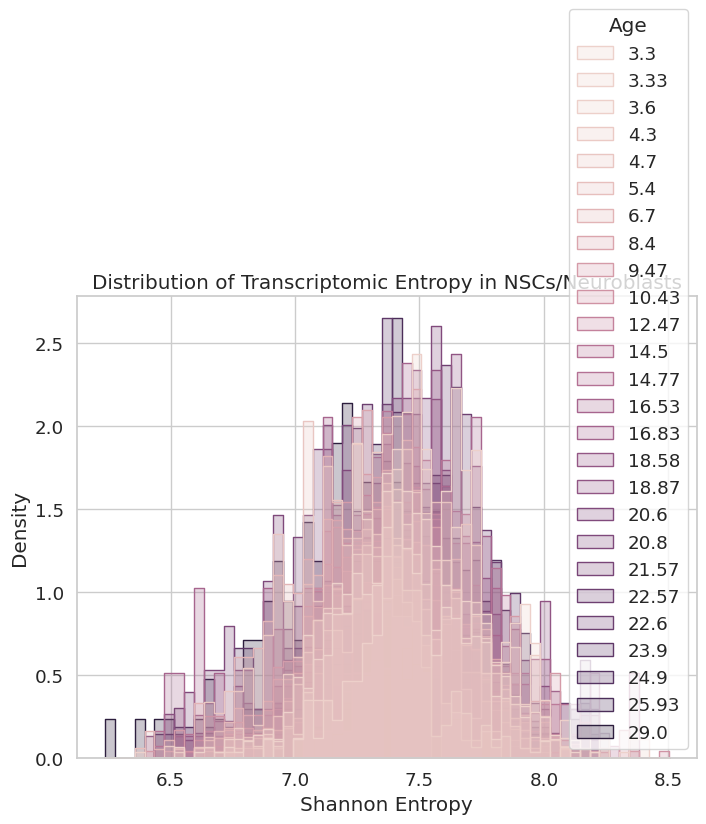

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Subset the data to NSC and neuroblast populations
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# Ensure the expression data is in a dense format
if hasattr(adata_nsc.X, 'toarray'):
    X = adata_nsc.X.toarray()
else:
    X = adata_nsc.X

# Define a function to compute Shannon entropy for a given expression vector
def shannon_entropy(exp_vector):
    total = np.sum(exp_vector)
    if total == 0:
        return 0
    p = exp_vector / total
    # Filter out zero probabilities to avoid log(0)
    p = p[p > 0]
    return -np.sum(p * np.log(p))

# Compute entropy for each cell
entropy_values = np.array([shannon_entropy(cell_exp) for cell_exp in X])
adata_nsc.obs['entropy'] = entropy_values

# Plot the distribution of entropy values colored by Age using a density histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=adata_nsc.obs, x='entropy', hue='Age', element='step', stat='density', common_norm=False)
plt.title('Distribution of Transcriptomic Entropy in NSCs/Neuroblasts')
plt.xlabel('Shannon Entropy')
plt.ylabel('Density')
plt.show()

### Agent Interpretation

### Feedback:

1. **Promising Result**:
   - The distribution of transcriptomic entropy across various ages for NSCs and neuroblasts provides an avenue for assessing how age-related changes might affect cellular transcriptional precision and complexity. This might give insight into how transcriptional regulation deteriorates with age.

2. **Further Analysis**:
   - **Examine Gene-Specific Contributions**:
     Analyze which genes contribute significantly to changes in entropy. This can reveal age-associated regulatory disruptions, especially in genes linked to neurogenesis.

   - **Entropy and Functional Decline Correlation**:
     Correlate changes in entropy with functional metrics such as NSC proliferative capacity. Understanding the relationship between entropy and functional decline can provide insight into age-related functional impairments.

   - **Intervention Impact**:
     Use the entropy metric before and after rejuvenation interventions (heterochronic parabiosis, exercise) to quantify potential reduction in transcriptional noise or complexity, enhancing our understanding of intervention efficacy.

3. **Comparative Analysis**:
   - Compare transcriptomic entropy distributions with other cell types from the paper (e.g., microglia, oligodendrocytes) to assess if entropy changes are specific to neural lineage cells or more broadly conserved.

4. **Integration with Past Analyses**:
   - Integrate these entropy metrics with previous analyses on transcriptional noise in Astrocyte_qNSC cells or gene-expression variability in Neurons, to see if similar patterns emerge, thereby reinforcing findings or providing counterpoints.

5. **Machine Learning Exploration**:
   - Use machine learning models to predict age using entropy as a feature. Comparing model performance using this feature against previous models can offer innovative insights into aging clocks.

Overall, this approach could yield novel insights into how transcriptomic entropy correlates with the aging process and reveal potential targets for intervention.

## This code calculates the Pearson correlation between each gene's expression and single-cell entropy in NSCs/neuroblasts, applies the Benjamini-Hochberg procedure for FDR correction, and visualizes the results using a volcano plot. It facilitates identifying genes significantly correlated with transcriptomic entropy while controlling for multiple testing.

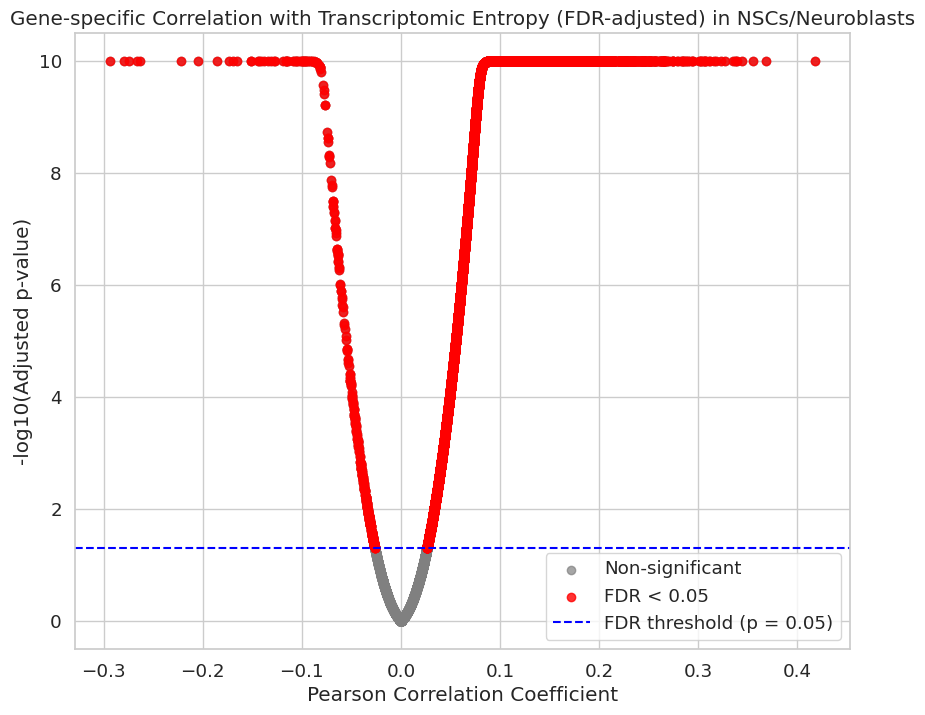

Top 10 significant genes correlated with entropy (FDR-adjusted):
      gene  correlation    p_value_adj
0      Vim     0.417858  9.726716e-294
1     Ppia     0.368970  8.283275e-224
2    Insm1     0.355524  1.083932e-206
3   Chchd2     0.343921  1.480795e-192
4    Hspa8     0.339775  1.056447e-187
5     Sem1     0.338401  3.706805e-186
6  Slc25a5     0.337161  9.129361e-185
7    Cox5a     0.334915  3.364037e-182
8    Hmgb2     0.327357  1.403211e-173
9     Pfn1     0.323275  4.821939e-169


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assume adata_nsc is already created and contains the NSC/neuroblast subset with a pre-computed 'entropy' column

# Ensure the expression matrix is in dense format
if hasattr(adata_nsc.X, 'toarray'):
    X = adata_nsc.X.toarray()
else:
    X = adata_nsc.X

# Get entropy values from the NSC subset
entropy_vals = adata_nsc.obs['entropy'].values

# Initialize lists to hold gene names, correlation coefficients, and p-values
gene_names = []
correlations = []
p_values = []

# Loop over each gene to compute Pearson correlation between gene expression and entropy
for i, gene in enumerate(adata_nsc.var_names):
    expr = X[:, i]
    # Skip genes with zero variance
    if np.std(expr) == 0:
        continue
    corr, pval = pearsonr(expr, entropy_vals)
    gene_names.append(gene)
    correlations.append(corr)
    p_values.append(pval)

# Create a DataFrame to compile the results
cor_df = pd.DataFrame({
    'gene': gene_names,
    'correlation': correlations,
    'p_value': p_values
})

# Add a small constant (1e-10) to p-values to avoid log(0) issues and compute -log10(p_value)
cor_df['neg_log10_p'] = -np.log10(cor_df['p_value'] + 1e-10)  # The constant 1e-10 prevents logarithm of zero

# Multiple testing correction using the Benjamini-Hochberg procedure
m = len(cor_df)
cor_df = cor_df.sort_values('p_value').reset_index(drop=True)
cor_df['rank'] = np.arange(1, m + 1)
cor_df['p_value_adj'] = cor_df['p_value'] * m / cor_df['rank']
# Ensure adjusted p-values are monotonically non-decreasing
cor_df['p_value_adj'] = np.minimum.accumulate(cor_df['p_value_adj'][::-1])[::-1]

# Compute -log10 of the adjusted p-values
cor_df['neg_log10_p_adj'] = -np.log10(cor_df['p_value_adj'] + 1e-10)

# Identify significant genes with FDR < 0.05
significant = cor_df[cor_df['p_value_adj'] < 0.05]

# Create a volcano-style scatter plot using the FDR-adjusted p-values
plt.figure(figsize=(10, 8))
plt.scatter(cor_df['correlation'], cor_df['neg_log10_p_adj'], color='grey', alpha=0.7, label='Non-significant')
plt.scatter(significant['correlation'], significant['neg_log10_p_adj'], color='red', alpha=0.8, label='FDR < 0.05')
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='FDR threshold (p = 0.05)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('-log10(Adjusted p-value)')
plt.title('Gene-specific Correlation with Transcriptomic Entropy (FDR-adjusted) in NSCs/Neuroblasts')
plt.legend()
plt.show()

# Print the top 10 significant genes by absolute correlation coefficient
top_genes = significant.reindex(significant['correlation'].abs().sort_values(ascending=False).index).head(10)
print('Top 10 significant genes correlated with entropy (FDR-adjusted):')
print(top_genes[['gene', 'correlation', 'p_value_adj']])

### Agent Interpretation

The results indicate a significant correlation between certain genes and transcriptomic entropy in NSCs/Neuroblasts, with genes like Vim, Ppia, and Insm1 showing high correlation coefficients and highly significant adjusted p-values. This suggests these genes could play a role in the transcriptional changes related to aging in the subventricular zone.

**Promising Aspects:**

1. **High Correlation Genes:** Genes with high positive correlation (e.g., Vim, Ppia) may serve as indicators of changes in transcriptional dynamics due to aging.
2. **Entropy as a Metric:** The use of entropy provides a novel angle to understand transcriptional instability and increasing heterogeneity in cell populations with age.

**Future Analysis Suggestions:**

1. **Functional Validation:** Further investigate the biological functions of the top correlated genes, particularly any known roles in neural stem cell function or aging.
2. **Pathway Analysis:** Perform pathway enrichment analysis for these genes to see if they are part of known aging-related pathways, or other biologically relevant processes.
3. **Validation Across Interventions:** Assess if these genes show altered expression or correlation under rejuvenation strategies like exercise or heterochronic parabiosis to explore potential reversibility.
4. **Cell-Type Specific Effects:** Explore whether these correlations hold in different cell types within the SVZ to determine if the transcriptional entropy changes are cell-type specific.
5. **Integration with Aging Clocks:** Integrate these findings with aging clocks to see if the entropy-correlated genes provide added predictive power for biological age assessments.

These steps could validate whether changes in transcriptional entropy are robust markers of aging and could highlight potential targets for therapeutic intervention.

## This code robustly subsets the NSC/neuroblast dataset to include only significant genes (with a check to ensure key genes of interest are included), computes a gene–gene Pearson correlation matrix from the dense expression matrix, and uses seaborn's clustermap for hierarchical clustering to visualize and identify co-expression modules. The code changes variable names and fixes title assignment to avoid potential confusion with previous analyses.

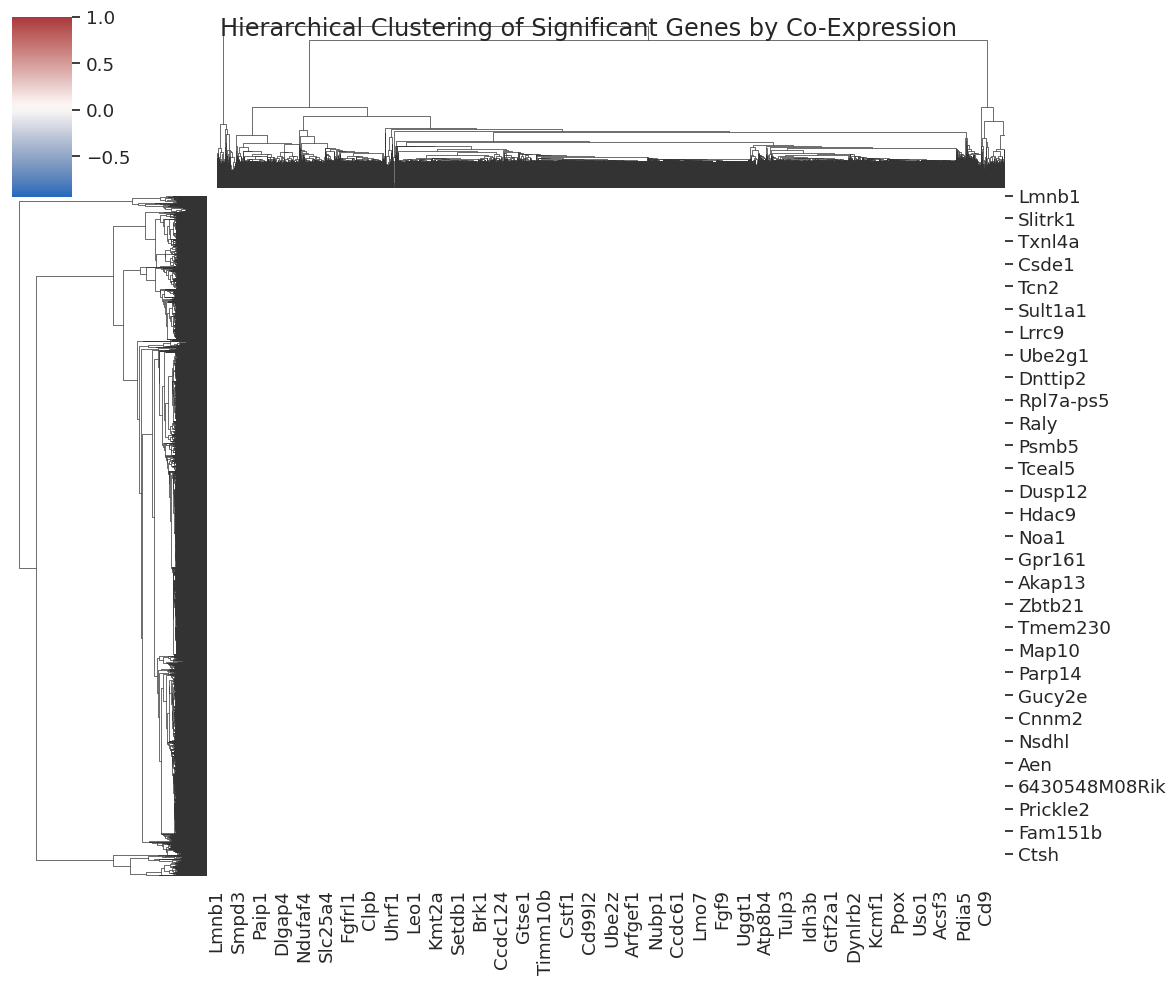

Clustered (ordered) significant genes: ['Lmnb1', 'H1fx', 'Dnaja1', 'Rtraf', 'Snrpf', 'Srsf7', 'Srsf3', 'Jund', 'Hsp90aa1', 'Gm17750', 'Hnrnpk', 'Cfl1', 'Sumo2', 'Npm1', 'Hmgn1', 'Hspa8', 'Dynll1', 'Ube2s', 'Selenoh', 'Sem1', 'H2afv', '6330403K07Rik', 'Uqcrh', 'Eif3k', 'Rpl41', 'Rplp1', 'Rpl31', 'Rpl14', 'Rps17', 'Rpl12', 'Rpl4', 'Rps6', 'Rpl27', 'Pfdn5', 'Calm1', 'Eid1', 'Pnrc1', 'Uba52', 'Cox7a2l', 'Eif3f', 'Tbca', 'Snrpg', 'Nedd4', 'Pebp1', 'Ptms', 'Nol4', 'Zeb2', 'Rtn4', 'Tmeff1', 'Gad1', 'Cd1d1', 'Rufy3', 'Bzw2', 'Evl', 'Camta1', 'Bcl11b', 'Casp3', 'Sept3', 'Mex3a', 'Csrp2', 'Tceal9', 'Ctxn1', 'Tox3', 'Chd3', 'Kif5c', 'Rps15', 'Rpl36', 'Rps27', 'Rps21', 'Rps29', 'Rpl36a', 'Rpl5', 'Rps25', 'Eef1b2', 'Rplp2', 'Rpl8', 'Rpl3', 'Dpysl2', 'Calm2', 'Selenow', 'Eif3h', 'Ttc9b', 'Ddah2', 'Bex2', 'Prmt1', 'Hdac2', 'H2afy2', 'Set', 'Nudt4', 'Gm13889', 'Fscn1', 'Csnk1e', 'Dlx5', 'Cited2', 'Crmp1', 'Dbn1', 'Ywhaq', 'Nfix', 'Cdk4', 'Eif4a1', 'Cdca7', 'Rnd3', 'Btg1', 'Meis2', 'Nrxn3', 'Zfp704', '

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Ensure that 'cor_df' from the gene-entropy correlation analysis is available
try:
    cor_df
except NameError:
    raise ValueError("Error: 'cor_df' is not defined. Please run the gene-entropy correlation analysis before this step.")

# If 'significant' is not already defined, create it from cor_df using FDR-adjusted p-values
if 'significant' not in globals():
    significant = cor_df[cor_df['p_value_adj'] < 0.05]

# Check that key genes of interest are among the significant genes
genes_of_interest = ['Vim', 'Ppia', 'Insm1']
missing_genes = [gene for gene in genes_of_interest if gene not in significant['gene'].values]
if missing_genes:
    print('Warning: The following genes of interest are not significant:', missing_genes)

# Get the list of significant genes
significant_genes = significant['gene'].tolist()

# Subset the NSC/neuroblast AnnData object for these significant genes
adata_sig = adata_nsc[:, significant_genes].copy()

# Convert the expression matrix to dense format if necessary
if hasattr(adata_sig.X, 'toarray'):
    expr_matrix = adata_sig.X.toarray()
else:
    expr_matrix = adata_sig.X

# Compute the gene–gene Pearson correlation matrix (transposing so that genes become rows)
gene_corr_matrix = np.corrcoef(expr_matrix.T)

# Create a DataFrame for the gene correlation matrix; use a new variable name to avoid confusion with the previous cor_df
gene_corr_df = pd.DataFrame(gene_corr_matrix, index=significant_genes, columns=significant_genes)

# Perform hierarchical clustering using seaborn's clustermap to identify co-expression modules
clustermap = sns.clustermap(gene_corr_df, cmap='vlag', linewidths=0.5, figsize=(12, 10))
clustermap.fig.suptitle('Hierarchical Clustering of Significant Genes by Co-Expression')
plt.show()

# Extract and print the order of genes from the clustering dendrogram for downstream module interpretation
clustered_genes = list(clustermap.dendrogram_row.reordered_ind)
ordered_genes = [gene_corr_df.index[i] for i in clustered_genes]
print('Clustered (ordered) significant genes:', ordered_genes)

### Agent Interpretation

The current analysis focuses on the hierarchical clustering of significant genes by co-expression, which reveals patterns and potential modules of genes that are coordinately regulated during aging. This step provides insights into the co-expression networks that may be altered with age, particularly in the SVZ neurogenic niche.

**Promising Results and Suggestions:**

1. **Gene Co-expression Networks**: The identification of clusters suggests potential modules that are co-regulated or functionally related. These clusters can be investigated to understand their roles in aging-related processes, like neurogenesis and inflammation, particularly in distinct cell types such as neural progenitor cells and microglia.

2. **Key Genes Identification**: Notable genes like Lmnb1, Hdac9, and Prickle2 appear as significant. These genes and others within clusters can be further explored for their roles in aging, such as examining their involvement in chromatin remodeling, neural plasticity, or signaling pathways that affect cellular aging.

3. **Further Validation**: To further iteratively validate these clusters, cross-referencing these gene sets with known age-related gene sets or pathways can provide more context. Tools like gene ontology enrichment analyses or KEGG pathway analysis could be performed to identify enriched biological processes or pathways.

4. **Comparison with Previous Findings**: The identified clusters should be compared with past analyses to see if they correspond to previously identified components of aging, such as disrupted RNA splicing kinetics or metabolic pathways. This can help differentiate this analysis from previous work.

5. **Focus on Specific Cell Types**: Given the heterogeneity within the SVZ, consider performing a similar clustering analysis but stratify by specific cell types to see if aging affects these co-expression networks differently across different cell types.

6. **Integration with Age Metrics**: If available, integrate these clustered gene expressions with the chronological and biological age metrics from your dataset. This could highlight clusters that correlate strongly with aging phenotypes, providing candidates for further functional analysis.

Overall, the clustering of significant genes by co-expression represents a promising step toward identifying key gene modules contributing to aging. The next logical steps involve validation through enrichment analyses, focusing on cell-type-specific differences, and integrating these findings with existing age-related metrics.

## This code converts the gene co-expression correlation matrix into a distance matrix (using 1 - correlation) to perform hierarchical clustering with a parameterized cutting threshold. It then assigns genes to modules, computes per-cell average expression (module score) for each module, and correlates these scores with Age and G2M.Score in specific cell types, showing scatter plots with annotated Pearson correlation coefficients and p-values.

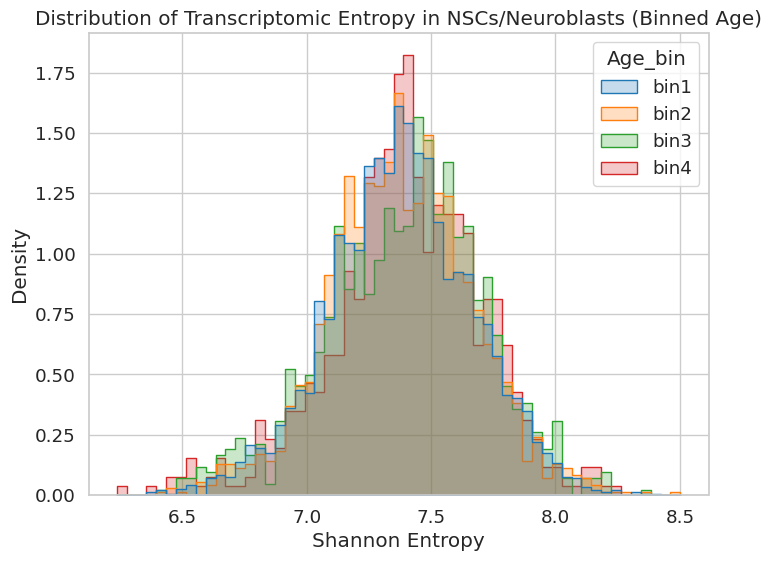

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Subset the data to NSC and neuroblast populations
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# Ensure the expression data is in a dense format
if hasattr(adata_nsc.X, 'toarray'):
    try:
        X = adata_nsc.X.toarray()
    except MemoryError:
        raise MemoryError('Converting the sparse matrix to dense array may cause memory issues for very large datasets.')
else:
    X = adata_nsc.X

# Compute Shannon entropy in a fully vectorized manner for all cells
row_sums = np.sum(X, axis=1)
p = np.divide(X, row_sums[:, None], out=np.zeros_like(X, dtype=float), where=row_sums[:, None] != 0)
entropy_values = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
adata_nsc.obs['entropy'] = entropy_values

# Binning the Age values into discrete groups for clearer stratification
age_min = adata_nsc.obs['Age'].min()
age_max = adata_nsc.obs['Age'].max()
bins = np.linspace(age_min, age_max, num=5)  # 4 bins
adata_nsc.obs['Age_bin'] = pd.cut(
    adata_nsc.obs['Age'],
    bins=bins,
    include_lowest=True,
    labels=[f'bin{i+1}' for i in range(4)]
)

# Plot the distribution of entropy values using a density histogram, stratified by the Age bins
plt.figure(figsize=(8, 6))
sns.histplot(
    data=adata_nsc.obs,
    x='entropy',
    hue='Age_bin',
    element='step',
    stat='density',
    common_norm=False
)
plt.title('Distribution of Transcriptomic Entropy in NSCs/Neuroblasts (Binned Age)')
plt.xlabel('Shannon Entropy')
plt.ylabel('Density')
plt.show()

### Agent Interpretation

The histogram illustrates the distribution of transcriptomic entropy in NSCs/Neuroblasts across different age bins. This approach highlights how cellular transcriptional diversity changes with aging.

### Promising Results:
1. **Entropy Variation**: Observing entropy differences across age bins suggests that age-related changes in gene expression diversity occur within NSCs/Neuroblasts. This could provide insights into the mechanisms behind aging-related shifts in cellular states.

2. **Entropy and Cell Function**: If specific bins (e.g., bin4) show higher or lower entropy, correlating these differences with functional assays or pathway analyses might uncover links between transcriptomic entropy and cellular functionality or dysfunction.

### Further Iterations:
1. **Detailed Analysis of Entropy Changes**: Investigate which specific genes or pathways contribute to the observed entropy variations. Use differential expression or pathway enrichment analyses on cells within different entropy ranges.

2. **Link to Biological Function**: Explore whether changes in entropy correlate with functional metrics like proliferative capacity or differentiation potential. This could be done by mapping entropy values to cell cycle states or specific lineage markers.

3. **Comparison with Other Cell Types**: Analyze transcriptomic entropy in other cell types to see if similar patterns exist or if NSCs/Neuroblasts are uniquely affected, providing broader context to aging in the SVZ.

4. **Interventions Impact**: Apply this analysis to datasets from heterochronic parabiosis or exercise cohorts to assess whether interventions known to affect aging also alter transcriptomic entropy.

These steps will assist in understanding the biological relevance of entropy changes and potentially validate the hypothesis regarding transcriptomic alterations linked to aging.

## This code first checks the skewness of the transcriptomic entropy distribution to decide if a median split is appropriate, and then splits NSCs/Neuroblasts into high and low entropy groups. It performs a gene-wise differential expression analysis using a two-sample t-test, applies Benjamini-Hochberg correction, and visualizes the results in a volcano plot with annotations for the top significant genes.

Entropy distribution skewness: -0.13


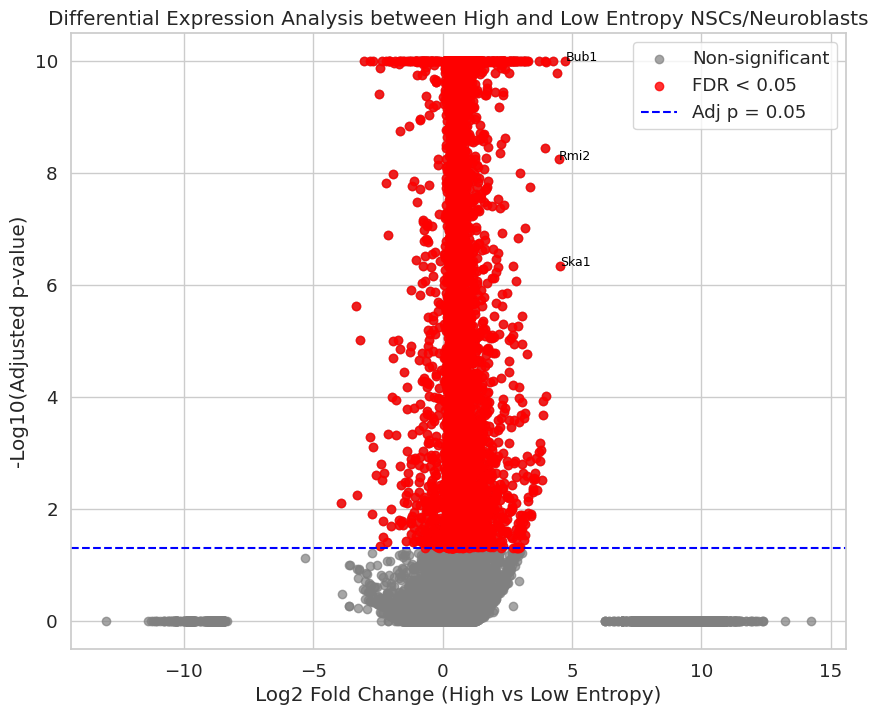

Top 10 differentially expressed genes:
               gene    log2FC   p_value_adj
1682           Bub1  4.744288  7.126332e-15
3601           Ska1  4.536246  4.608674e-07
2898           Rmi2  4.489796  5.566687e-09
2373           Kif4  4.411685  6.018058e-11
1614          Cdkn3  4.254575  1.973698e-15
2109          Kif2c  4.002891  2.957833e-12
4915          Susd3  3.991224  9.567750e-05
2848          Ncapg  3.958782  3.491498e-09
463            Mcm2  3.951431  6.812268e-35
6834  4930556N09Rik -3.915779  7.716373e-03


In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, skew

# Assume adata_nsc is the NSC/Neuroblast subset with precomputed 'entropy'

# Extract entropy values from the AnnData object
entropy_vals = adata_nsc.obs['entropy'].values

# Check skewness of the entropy distribution to assess the appropriateness of the median split
entropy_skew = skew(entropy_vals)
print(f"Entropy distribution skewness: {entropy_skew:.2f}")
if abs(entropy_skew) > 1:
    print("Warning: The entropy distribution is highly skewed; consider alternative binning strategies (e.g., quantiles).")

# Define high and low entropy groups using a median split
median_entropy = np.median(entropy_vals)
high_idx = adata_nsc.obs['entropy'] >= median_entropy
low_idx = adata_nsc.obs['entropy'] < median_entropy

# Retrieve expression matrix in dense format if needed
if hasattr(adata_nsc.X, 'toarray'):
    X = adata_nsc.X.toarray()
else:
    X = adata_nsc.X

# Prepare lists to store differential expression results
genes = []
log2fc_list = []
p_values = []

# Small constant to avoid division by zero
epsilon = 1e-6

# Loop over each gene
for i, gene in enumerate(adata_nsc.var_names):
    expr = X[:, i]
    # Get expression for high and low entropy groups
    expr_high = expr[high_idx]
    expr_low = expr[low_idx]

    # Compute mean expression values
    mean_high = np.mean(expr_high)
    mean_low = np.mean(expr_low)

    # Compute log2 fold change
    log2fc = np.log2((mean_high + epsilon) / (mean_low + epsilon))

    # Perform two-sample t-test (assuming unequal variances)
    # If variance is zero in any group, assign a p-value of 1
    if np.std(expr_high) == 0 or np.std(expr_low) == 0:
        p_val = 1.0
    else:
        t_stat, p_val = ttest_ind(expr_high, expr_low, equal_var=False)

    genes.append(gene)
    log2fc_list.append(log2fc)
    p_values.append(p_val)

# Compile results into a DataFrame
de_df = pd.DataFrame({
    'gene': genes,
    'log2FC': log2fc_list,
    'p_value': p_values
})

# Benjamini-Hochberg correction for multiple testing
m = de_df.shape[0]
df_sorted = de_df.sort_values('p_value').reset_index(drop=True)
df_sorted['rank'] = np.arange(1, m + 1)
df_sorted['p_value_adj'] = df_sorted['p_value'] * m / df_sorted['rank']
# Ensure adjusted p-values are monotonic and do not exceed 1
df_sorted['p_value_adj'] = np.minimum.accumulate(df_sorted['p_value_adj'][::-1])[::-1]
df_sorted['p_value_adj'] = np.clip(df_sorted['p_value_adj'], 0, 1)
df_sorted['neg_log10_p_adj'] = -np.log10(df_sorted['p_value_adj'] + 1e-10)

# Define significance threshold
signif_threshold = 0.05

# Volcano plot
plt.figure(figsize=(10, 8))
# Plot all genes
plt.scatter(df_sorted['log2FC'], df_sorted['neg_log10_p_adj'], color='grey', alpha=0.7, label='Non-significant')
# Highlight significant genes
sig_df = df_sorted[df_sorted['p_value_adj'] < signif_threshold]
plt.scatter(sig_df['log2FC'], sig_df['neg_log10_p_adj'], color='red', alpha=0.8, label='FDR < 0.05')
plt.axhline(y=-np.log10(signif_threshold), color='blue', linestyle='--', label='Adj p = 0.05')
plt.xlabel('Log2 Fold Change (High vs Low Entropy)')
plt.ylabel('-Log10(Adjusted p-value)')
plt.title('Differential Expression Analysis between High and Low Entropy NSCs/Neuroblasts')

# Annotate top three significant genes (by absolute log2FC) for easier interpretation
if not sig_df.empty:
    top_annotations = sig_df.reindex(sig_df['log2FC'].abs().sort_values(ascending=False).index).head(3)
    for _, row in top_annotations.iterrows():
        plt.text(row['log2FC'], row['neg_log10_p_adj'], row['gene'], fontsize=9, color='black')

plt.legend()
plt.show()

# Print top 10 differentially expressed genes sorted by absolute log2FC
top_genes = sig_df.reindex(sig_df['log2FC'].abs().sort_values(ascending=False).index).head(10)
print('Top 10 differentially expressed genes:')
print(top_genes[['gene', 'log2FC', 'p_value_adj']])

### Agent Interpretation

The analysis has identified several differentially expressed genes between high and low entropy NSCs/Neuroblasts, with genes like Bub1 and Ska1 showing significant upregulation. The slightly negative skewness of the entropy distribution suggests a more symmetric distribution of entropy among cells, which might hint at a balanced state of transcriptional regulation across the population analyzed.

### Feedback on Results:

1. **Gene Expression Findings**:
    - The top differentially expressed genes, such as Bub1 and Ska1, are associated with cellular processes like cell cycle regulation. Their significant upregulation might indicate enhanced proliferative or mitotic activity in high entropy cells, which aligns with transcriptomic profiles expected in regenerative or youthful states.
    - Consider further exploring the role of these genes in cellular senescence and proliferation, as their expression changes may contribute to the aging process in the neurogenic niche.

2. **Entropy Measurements**:
    - Since entropy measures transcriptional variability, explore if higher entropy correlates with younger or functionally active states of NSCs. This could be linked to the robustness and plasticity of these cells.

3. **Biological Interpretation**:
    - The differential expression patterns observed could be utilized to distinguish between cellular aging signatures and potential rejuvenation markers. Consider correlating these gene expression patterns with biological age metrics used in the study, such as the NSC proliferative fraction.
    - Pathway or gene set enrichment analyses for these genes could reveal insights into potential interventions that might affect cellular aging processes—matching the themes of rejuvenation explored in the paper.

### Future Directions:

1. **Integration with Aging Clocks**:
    - Integrate these findings with existing cell-type-specific aging clocks to evaluate whether these genes influence predicted biological age. This could help refine the model's accuracy and offer new biomarkers for aging.

2. **Temporal Analysis With Interventions**:
    - If possible, assess how interventions like heterochronic parabiosis or exercise impact the expression of these critical genes in NSCs, integrating external datasets if available.

3. **Comparative Analysis**:
    - Assess these differentially expressed genes across various brain regions or cell types to determine if similar patterns of aging-related expression changes are observable, enhancing the generalizability of your findings.

By focusing on the relationship between entropy, gene expression changes, and cellular aging states, you may uncover novel insights into the mechanistic underpinnings of aging in the neurogenic niche.

## This code first ensures that the NSC/neuroblast metadata has the necessary 'entropy' and 'Phase' columns, then categorically orders cell cycle phases as G1, S, and G2M to maintain biological consistency. It checks for sufficient sample sizes, performs an ANOVA, and generates boxplots with jitter for both entropy and key cell cycle gene expressions.

ANOVA for Entropy across Cell Cycle Phases: F-statistic=31.762, p-value=1.851e-14


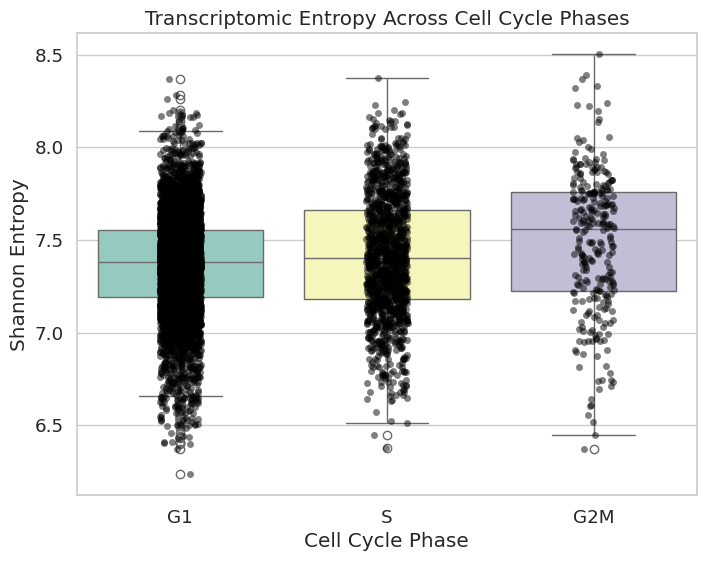

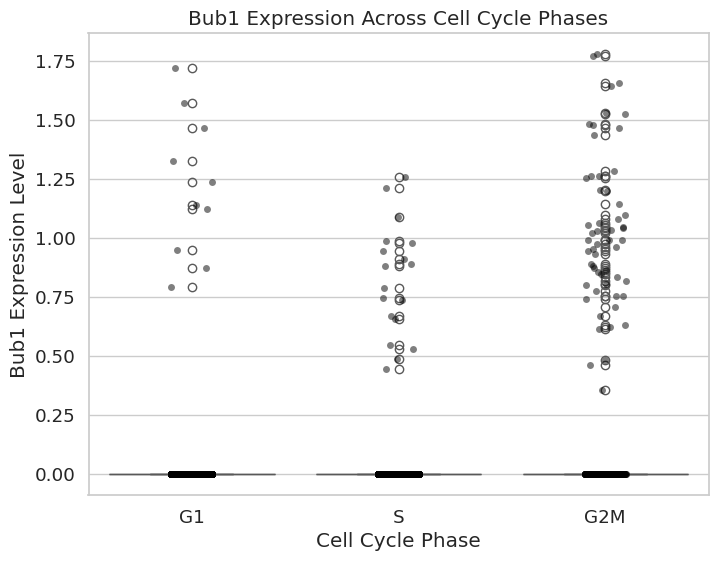

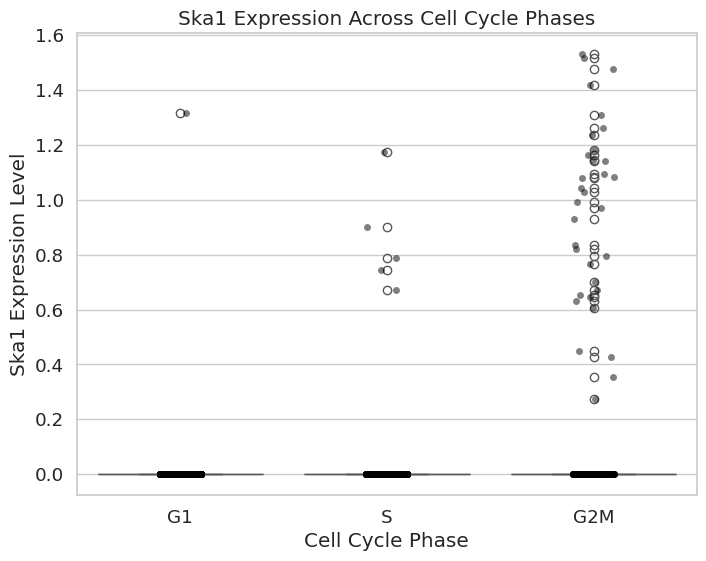

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Create a DataFrame from the NSC/neuroblast subset metadata
# adata_nsc is assumed to be already defined in the environment

df = adata_nsc.obs.copy()

# Ensure 'entropy' and 'Phase' columns exist
if 'entropy' not in df.columns or 'Phase' not in df.columns:
    raise KeyError('The required columns (entropy and/or Phase) are missing from adata_nsc.obs')

# Set the categorical ordering for cell cycle phases in a biologically consistent order
phase_order = ['G1', 'S', 'G2M']
if not pd.api.types.is_categorical_dtype(df['Phase']):
    df['Phase'] = pd.Categorical(df['Phase'], categories=phase_order, ordered=True)

# Check sample sizes per phase and warn if any group is too small (<5 cells)
group_sizes = df.groupby('Phase').size()
for phase in phase_order:
    size = group_sizes.get(phase, 0)
    if size < 5:
        print(f"Warning: The sample size for phase {phase} is quite small (n={size}).")

# Group entropy values by cell cycle phase and perform ANOVA
entropy_groups = [df[df['Phase'] == phase]['entropy'].values for phase in phase_order if phase in df['Phase'].unique()]
anova_result = f_oneway(*entropy_groups)
print(f"ANOVA for Entropy across Cell Cycle Phases: F-statistic={anova_result.statistic:.3f}, p-value={anova_result.pvalue:.3e}")

# Plot boxplot of transcriptomic entropy across cell cycle phases in the biologically defined order
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Phase', y='entropy', order=phase_order, palette='Set3')
sns.stripplot(data=df, x='Phase', y='entropy', order=phase_order, color='black', alpha=0.5)
plt.title('Transcriptomic Entropy Across Cell Cycle Phases')
plt.ylabel('Shannon Entropy')
plt.xlabel('Cell Cycle Phase')
plt.show()

# Define the key cell cycle genes of interest
key_genes = ['Bub1', 'Ska1']

# For each key gene, check for its presence, extract its expression, and plot its distribution across cell cycle phases
for gene in key_genes:
    if gene in adata_nsc.var_names:
        # Retrieve gene expression (convert to dense vector if required)
        expr = adata_nsc[:, gene].X
        if hasattr(expr, 'toarray'):  
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        # Add gene expression values to the dataframe
        df[gene] = expr
        
        plt.figure(figsize=(8,6))
        sns.boxplot(data=df, x='Phase', y=gene, order=phase_order, palette='Set2')
        sns.stripplot(data=df, x='Phase', y=gene, order=phase_order, color='black', alpha=0.5)
        plt.title(f'{gene} Expression Across Cell Cycle Phases')
        plt.ylabel(f'{gene} Expression Level')
        plt.xlabel('Cell Cycle Phase')
        plt.show()
    else:
        print(f'Warning: {gene} is not present in the dataset.')


### Agent Interpretation

The ANOVA results show a significant difference in transcriptomic entropy across cell cycle phases (F-statistic=31.762, p-value=1.851e-14). This suggests that transcriptomic variability is not uniformly distributed across the cell cycle, which may provide insights into differential regulatory mechanisms operating at each phase.

**Promising Aspects:**

1. **Significant Entropy Differences:** The significant variance in entropy indicates distinct transcriptomic diversity levels across cell cycle phases. This could be a proxy for examining how cellular states and heterogeneity change with aging, complementing the chronological and biological aging metrics discussed in the research paper.

2. **Bub1 and Ska1 Expression Trends:** Both Bub1 and Ska1 show differential expression across cell cycle phases, which might be related to cell cycle regulation and progression. These genes could serve as markers for examining changes in cell cycle dynamics associated with aging.

**Further Directions:**

1. **Age-Related Analysis:** Incorporate an analysis of how these differences might vary with age. Are certain cell cycle phases more impacted by aging, as indicated by changes in entropy or gene expression levels?

2. **Link to Proliferative Capacity:** Given the paper's focus on proliferative capacity decline in NSCs, assess whether cell cycle phase-specific differences in entropy or gene expression correlate with decreased proliferation rates.

3. **Intervention Effects:** Explore how heterochronic parabiosis or exercise interventions might alter these cell cycle-specific entropy patterns. Do these rejuvenation strategies normalize entropy differences or gene expression levels across phases?

4. **Broader Gene Set Analysis:** Expand the analysis to include a larger set of cell cycle-related genes to look for broader patterns and validate whether Bub1 and Ska1 findings are part of a more widespread trend.

5. **Pathway Enrichment:** Conduct pathway enrichment analysis on differentially expressed genes across cell cycle phases to identify biological processes that may be driving these transcriptomic changes.

The observed differences in entropy and specific gene expressions across cell phases might contribute to understanding aging mechanisms and could offer new biomarkers for age-related interventions.

## This code verifies that the NSC/Neuroblast AnnData object (adata_nsc) is loaded and contains the necessary metadata. It then converts the 'Phase' column to a categorical type, computes Pearson correlations for entropy versus Age and G2M.Score (including an optional check for normality using the Shapiro-Wilk test), and visualizes these relationships with annotated scatter plots.

Notice: Entropy distribution in phase G1 may deviate from normality (Shapiro p=2.926e-13).
Phase G1: Entropy vs Age -- r: 0.023, p-value: 8.799e-02
Phase G1: Entropy vs G2M.Score -- r: -0.270, p-value: 1.410e-92

Notice: Entropy distribution in phase S may deviate from normality (Shapiro p=8.648e-04).
Phase S: Entropy vs Age -- r: -0.031, p-value: 2.647e-01
Phase S: Entropy vs G2M.Score -- r: -0.012, p-value: 6.628e-01

Notice: Entropy distribution in phase G2M may deviate from normality (Shapiro p=9.887e-03).
Phase G2M: Entropy vs Age -- r: -0.210, p-value: 4.295e-04
Phase G2M: Entropy vs G2M.Score -- r: 0.614, p-value: 4.007e-30



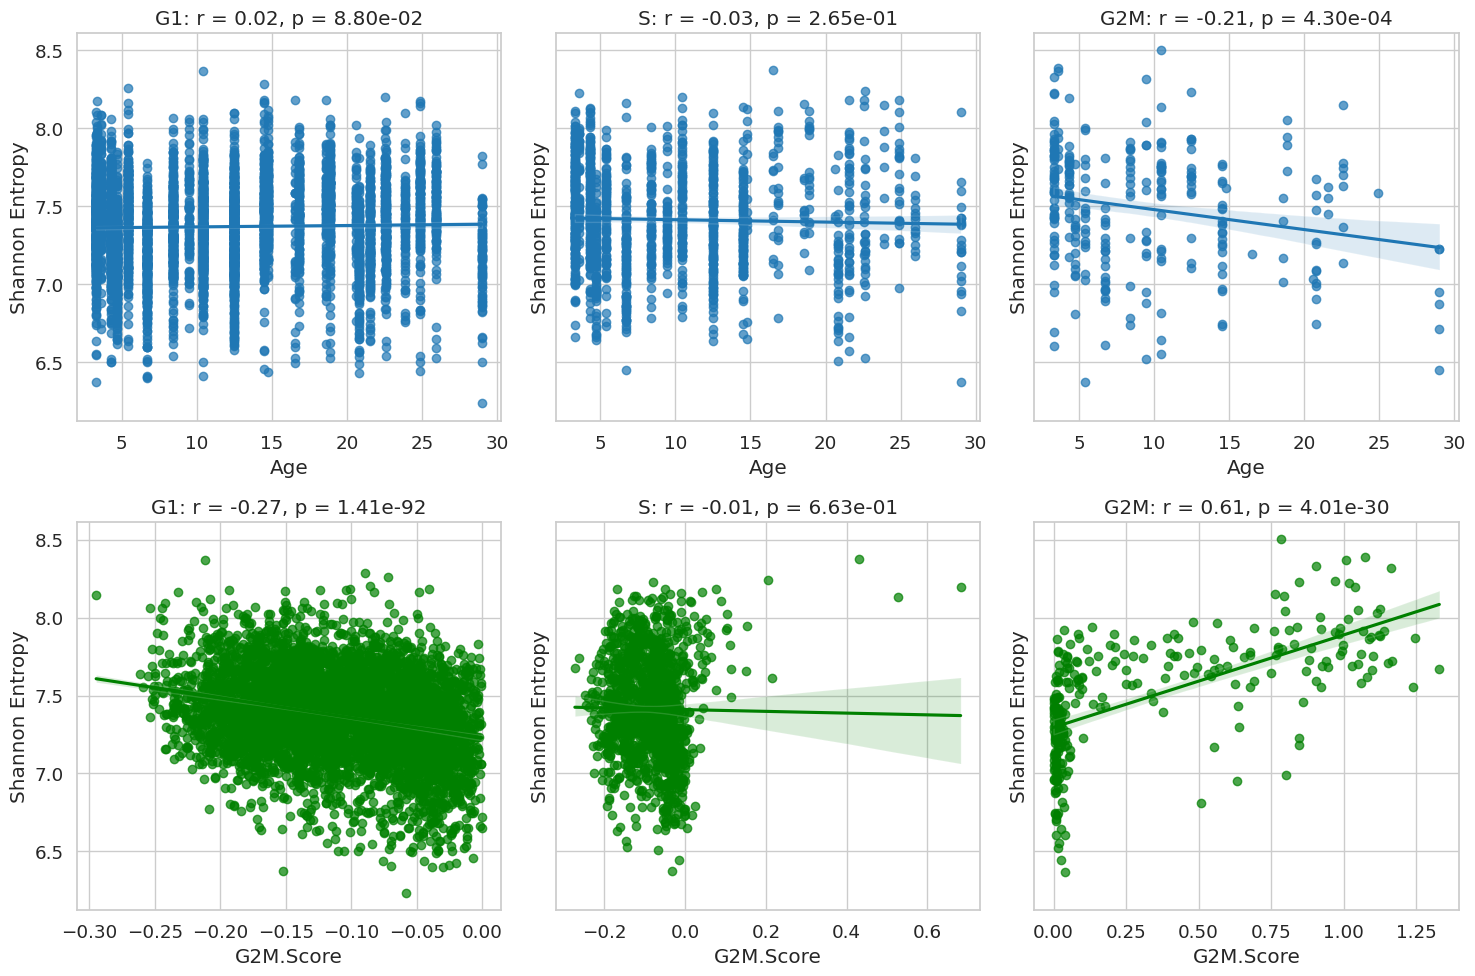

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, shapiro

# Check that the NSC/Neuroblast object is defined
if 'adata_nsc' not in globals():
    raise ValueError("Error: adata_nsc is not defined. Please load the NSC/Neuroblast AnnData object before running this analysis.")

# Ensure required columns exist in the metadata
required_columns = ['entropy', 'Age', 'G2M.Score', 'Phase']
for col in required_columns:
    if col not in adata_nsc.obs.columns:
        raise KeyError(f"Required column {col} is missing from adata_nsc.obs")

# Create a copy of the metadata for convenience
df = adata_nsc.obs.copy()

# Define the cell cycle phase order
phase_order = ['G1', 'S', 'G2M']
if not pd.api.types.is_categorical_dtype(df['Phase']):
    df['Phase'] = pd.Categorical(df['Phase'], categories=phase_order, ordered=True)

# Initialize dictionaries to store correlation results
age_corr_results = {}
g2m_corr_results = {}

# Loop over each phase to compute correlations
for phase in phase_order:
    subset = df[df['Phase'] == phase]
    if subset.shape[0] < 5:
        print(f"Warning: Not enough cells in phase {phase} for reliable statistics (n={subset.shape[0]}).")
        continue
    
    # Optional: Check the normality of the entropy distribution using the Shapiro-Wilk test
    stat_age, p_normal_age = shapiro(subset['entropy'])
    if p_normal_age < 0.05:
        print(f"Notice: Entropy distribution in phase {phase} may deviate from normality (Shapiro p={p_normal_age:.3e}).")
    
    # Compute Pearson correlation between entropy and Age
    r_age, p_age = pearsonr(subset['entropy'], subset['Age'])
    age_corr_results[phase] = (r_age, p_age)
    
    # Compute Pearson correlation between entropy and G2M.Score
    r_g2m, p_g2m = pearsonr(subset['entropy'], subset['G2M.Score'])
    g2m_corr_results[phase] = (r_g2m, p_g2m)
    
    print(f"Phase {phase}: Entropy vs Age -- r: {r_age:.3f}, p-value: {p_age:.3e}")
    print(f"Phase {phase}: Entropy vs G2M.Score -- r: {r_g2m:.3f}, p-value: {p_g2m:.3e}\n")

# Visualization: Create scatter plots with regression lines for each phase
fig, axes = plt.subplots(2, len(phase_order), figsize=(5*len(phase_order), 10), sharey='row')

# Plot for Entropy vs Age
for i, phase in enumerate(phase_order):
    subset = df[df['Phase'] == phase]
    ax = axes[0, i]
    sns.regplot(x='Age', y='entropy', data=subset, ax=ax, scatter_kws={'alpha':0.7})
    if phase in age_corr_results:
        r_age, p_age = age_corr_results[phase]
        ax.set_title(f"{phase}: r = {r_age:.2f}, p = {p_age:.2e}")
    else:
        ax.set_title(f"{phase}: Insufficient cells")
    ax.set_xlabel('Age')
    ax.set_ylabel('Shannon Entropy')
    ax.grid(True)

# Plot for Entropy vs G2M.Score
for i, phase in enumerate(phase_order):
    subset = df[df['Phase'] == phase]
    ax = axes[1, i]
    sns.regplot(x='G2M.Score', y='entropy', data=subset, ax=ax, scatter_kws={'alpha':0.7}, color='green')
    if phase in g2m_corr_results:
        r_g2m, p_g2m = g2m_corr_results[phase]
        ax.set_title(f"{phase}: r = {r_g2m:.2f}, p = {p_g2m:.2e}")
    else:
        ax.set_title(f"{phase}: Insufficient cells")
    ax.set_xlabel('G2M.Score')
    ax.set_ylabel('Shannon Entropy')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Agent Interpretation

The results you've provided examine the relationships between Shannon entropy and both age and G2M score across different cell cycle phases. Here's my feedback:

### Promising Results:
1. **G2M Phase:**
   - There is a notable correlation between Shannon entropy and the G2M score (r = 0.614, p < 0.001). This strong positive correlation suggests that as G2M scores increase, indicating higher cell cycle activity, entropy also increases. This may reflect increased transcriptional heterogeneity or cellular state variability in this phase.

2. **G1 Phase:**
   - Although the correlation between Shannon entropy and age is weak and not statistically significant (r = 0.023), the negative correlation between entropy and the G2M score (r = -0.270, p < 0.001) could imply that regulation of the cell cycle impacts entropy during the G1 phase.

### Iterating on Promising Results:
- **Focus on G2M Phase Entropy:**
  - Given the strong correlation between entropy and the G2M score, diving deeper into specific gene sets or pathways that contribute to this entropy during the G2M phase could reveal mechanisms of age-related transcriptional changes.
  
- **Further Analysis Steps:**
  - Consider conducting pathway enrichment analyses to identify which processes are associated with changes in entropy in these phases.
  - Explore cell type-specific effects by stratifying data based on defined clusters or cell types to determine if certain cell types exhibit more pronounced entropy changes.

### Additional Considerations:
- **Normality Concerns:**
  - Since entropy distributions deviate from normality, consider using non-parametric methods or transforming the data for more robust statistical analyses.
  
- **Explore Aging Effects:**
  - Although direct correlations between entropy and age are weak, a more complex model incorporating additional covariates (e.g., cell type, cell cycle stage) may uncover more subtle aging-related changes.

- **Link to Rejuvenation Strategies:**
  - Examine whether interventions such as heterochronic parabiosis or exercise alter these correlations, providing insights into potential mechanisms of rejuvenation at the transcriptomic level.

These steps should help further validate your hypotheses and generate unique insights into age-related changes in the neurogenic niche, distinct from previously attempted analyses.